# Data Collection

Load in libraries and datasets. The datasets come from Kaggle, internet sources, and a basketball reference scrape.

In [1]:
# read in libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import BorderlineSMOTE 
from sklearn.feature_selection import RFE

# suppress unnecessary warnings
pd.options.mode.chained_assignment = None 
pd.errors.DtypeWarning = None 

In [2]:
# read in datasets

# kaggle datasets
games = pd.read_csv('data/games.csv') 
games_details = pd.read_csv('data/games_details.csv')
players = pd.read_csv('data/players.csv')
ranking = pd.read_csv('data/ranking.csv')
teams = pd.read_csv('data/teams.csv')

# datasets created from internet
jersey = pd.read_csv('data/jersey2.csv')
twok = pd.read_csv('data/2kRank.csv')
pacedata = {'season':[2012,2013,2014,2015,2016,2017,2018,2019,2020],
           'pace':[92.0,93.9,93.9,95.8,96.4,97.3,100.0,100.3,99.2]}
pace = pd.DataFrame(pacedata)

# load in scraped all star info
all_star_appearances = pickle.load(open('data/all_star_appearances.pickle', 'rb'))

C:\Users\stats\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Data Preparation

Merge date to the individual games dataset (one row for every player in every game) and use month and date to label each row with a season. The convention used is the first year in the season is the name of the season (i.e. 2015-2016 is the 2015 season). Then, filter for the relevant time periods, which are the months September through January for the 2012 - 2020 seasons. The 2020 NBA Championship games must then be removed because they took place in September and Ocotber due to postponements caused by COVID-19. There is also an issue with the 2020 data being duplicated so duplicates are removed.

In [3]:
# join date to individual games stats dataset
games_details2 = pd.merge(games_details, games[['GAME_DATE_EST', 'GAME_ID']], on = 'GAME_ID', how = 'left')

# extract year and month for every row
games_details2['year'] =  pd.to_numeric(games_details2['GAME_DATE_EST'].apply(lambda x: x.split('-')[0]))
games_details2['month'] =  pd.to_numeric(games_details2['GAME_DATE_EST'].apply(lambda x: x.split('-')[1]))

# label each row with season based on year and month
games_details2['season'] = games_details2[['year','month']].apply(lambda x: x['year']-1 if (x['month']==1) else x['year'], axis=1)

# keep only game info for September through January in the 2012-2020 seasons
games_details2 = games_details2[games_details2['month'].isin([9,10,11,12,1])]
games_details3 = games_details2[(games_details2['season']<2021) & (games_details2['season']>2011)]

# get rid of 2020 finals
games_details3 = games_details3[~((games_details3['season']==2020) & (games_details3['month'].isin([9,10])))]

# drop duplicates
games_details3 = games_details3.drop_duplicates(subset=['GAME_ID','PLAYER_ID'])

Prepares the individual games dataset to be summarized by player and season. It does this by getting rid of rows where the players did not play, getting rid of one erroneous row, extracting the number of minutes they played, and adding a helper column to indicate the player did play in the game.

In [4]:
# get rid of rows with comments (means they did not play)
games_details3 = games_details3[games_details3['COMMENT'].isnull()]

# get rid of one erroneous row
games_details3 = games_details3[games_details3['PTS'].notnull()]

# extract number of minutes played
games_details3['minutes'] =  pd.to_numeric(games_details3['MIN'].apply(lambda x: x.split(':')[0]))

# add a column to indicate they played in that game (useful for aggregation in next step)
games_details3['GP'] = 1

Finds the summary statistics by player and season for all the basic stats collected using groupby. This dataset forms the basis for the main dataset going forward.

In [5]:
# uses groupby to summarize by player and season
grouped = games_details3.groupby(['PLAYER_ID','season']).apply(lambda s: pd.Series({ 
    "PLAYER_NAME": s["PLAYER_NAME"].mode()[0],
    "TEAM_ABBREVIATION": s["TEAM_ABBREVIATION"].mode()[0],
    "TEAM_ID": s["TEAM_ID"].mode()[0],
    "GP": s["GP"].sum(),
    "Minutes": s["minutes"].mean(),
    "FGM": s["FGM"].mean(),
    "FGA": s["FGA"].mean(),
    "FG3M": s["FG3M"].mean(),
    "FG3A": s["FG3A"].mean(),
    "FTM": s["FTM"].mean(),
    "FTA": s["FTA"].mean(),
    "OREB": s["OREB"].mean(),
    "DREB": s["DREB"].mean(),
    "AST": s["AST"].mean(),
    "STL": s["STL"].mean(),
    "BLK": s["BLK"].mean(),
    "TO": s["TO"].mean(), 
    "PF": s["PF"].mean(),
    "PTS": s["PTS"].mean(),
    "PLUS_MINUS": s["PLUS_MINUS"].mean(),
    "Starting_Position": s["START_POSITION"].mode(),
})).reset_index()

Fix Starting_Position column so that the most common starting position for each player is displayed correctly and those with no information are labeled with "None".

In [6]:
# Fix Starting_Position column
grouped['Starting_Position'] = grouped['Starting_Position'].apply(lambda x: "None" if len(x)==0 else x[0])

Adjust each season for pace by merging the pace data and dividing the relevant columns by the pace/100.

In [7]:
# merge pace data
grouped = pd.merge(grouped, pace, on = ['season'], how = 'left')

# divide pace data by 100
grouped['pace'] = grouped['pace']/100

# divide relevant statistics by pace/100
grouped[['FGM','FGA','FG3M','FG3A','FTM','FTA','OREB',
       'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS']] = grouped[['FGM','FGA','FG3M','FG3A','FTM','FTA','OREB',
       'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS']].div(grouped.pace, axis=0)

Calculate Advanced Metrics PER and True Shooting Percentage.

In [8]:
# PER
grouped['PER'] = (grouped['FGM']*85.910 + grouped['STL']*53.897 + 
grouped['FG3M']*51.757 + grouped['FTM']*46.845 + grouped['BLK']*39.190
+ grouped['OREB']*39.190+ grouped['AST']*34.677 + grouped['DREB']*14.707
- grouped['PF']*17.174 - (grouped['FTA']-grouped['FTM'])*20.091 - (grouped['FGA']-grouped['FGM'])*39.190
- grouped['TO']*53.897)*(1/grouped['Minutes'])

# True Shooting Percentage
grouped['TSP'] = grouped['PTS']/(2*(grouped['FGA']+.44*grouped['FTA']))

Add each player's team win percentage and team conference for each season as of January 20. This is done first by keeping only the team ranking data as of January 20 for each season and adjusting the season ID to match the season. Then, this data is merged with the main data.

In [9]:
# keep only January 20 data
ranking2 = ranking[(ranking['STANDINGSDATE'].apply(lambda x: x.split('-')[1])=='01') & (ranking['STANDINGSDATE'].apply(lambda x: x.split('-')[2])=='20')]

# get season from the year
ranking2['season'] = ranking2['SEASON_ID']-20000
grouped = pd.merge(grouped, ranking2[['TEAM_ID', 'season','CONFERENCE','W_PCT']], on = ['TEAM_ID','season'], how = 'left')

Add if a player's jersey was in the top 15 of best sellers the previous year by merging with jersey data.

In [10]:
# merge jersey data
grouped = pd.merge(grouped, jersey, on = ['season','PLAYER_ID'], how = 'left')

Add the players' 2KRank for that season (released before the year starts).

In [11]:
# merge 2k data
grouped = pd.merge(grouped, twok[['PLAYER_ID','season','2KRank']],on=['PLAYER_ID','season'],how='left')

Adds All Star information for each player/season. Specifically, it adds wether a player was an All Star the previous year, the total amount of prior All Star selections a player had, and if a player was selected as an All Star that season (this is the target).

In [12]:
# function that defines if a player was an All star the previous year
def was_AS_last_year(row):
    if row['season'] == 1999:
        return 1 if 1998 in all_star_appearances[row['PLAYER_NAME']] else 0
    return 1 if row['season'] in all_star_appearances[row['PLAYER_NAME']] else 0

# adds if a player was an ALl star the previous year
grouped['LastASG?'] = grouped[['PLAYER_NAME', 'season']].apply(was_AS_last_year, axis=1)

# adds the total amount of prior selections a player had as of that year (not including that year)
grouped['PriorASG'] = grouped[['PLAYER_NAME', 'season']].apply(lambda row : sum(y<=row['season'] for y in all_star_appearances[row['PLAYER_NAME']]), axis=1)

# adds wether a player was selected as an all star that year
grouped['Selected?'] = grouped[['PLAYER_NAME', 'season']].apply(lambda row : 1 if row['season']+1 in all_star_appearances[row['PLAYER_NAME']] else 0, axis=1)

Adjusts for variability in games played up to that point in the season (especially relevant in 2020 season) by calculating the percentage of his team's games a player participated in.

In [13]:
# get total games played by each team up to that point in each season
game_count1 = games_details3.groupby(['season','GAME_ID','TEAM_ID']).GP.mean().reset_index()
game_count2 = game_count1.groupby(['season','TEAM_ID']).GP.sum().reset_index()

# merges Games Played rate with main dataset
grouped = pd.merge(grouped,game_count2,on=['season','TEAM_ID'],how='left')

# calculates percentage games played
grouped['GP_Per'] = grouped['GP_x'] / grouped['GP_y']

Null and infinite data is dealt with next, setting missing stats values to zero and giving unranked players a very low rank.

In [14]:
# get rid of inf
grouped.replace([np.inf, -np.inf], np.nan, inplace=True)

#fill null values
grouped['PLUS_MINUS'] = grouped['PLUS_MINUS'].fillna(0)
grouped['TSP'] = grouped['TSP'].fillna(0)
grouped['PER'] = grouped['PER'].fillna(0)
grouped['2KRank'] = grouped['2KRank'].fillna(500)

In the 2018 season All Star game, Dirk Nowitzki and Dwyane Wade were added as special additions to honor their legacy. They are removed from the dataset to not skew the data.

In [15]:
grouped.loc[(grouped['PLAYER_NAME']=='Dwyane Wade') & (grouped['season']==2018),'Selected?'] = 0
grouped.loc[(grouped['PLAYER_NAME']=='Dirk Nowitzki') & (grouped['season']==2018),'Selected?'] = 0

Use onehot encoding on the few categorical columns that are not already in the form 1/0 and drop columns not used in analysis.

In [16]:
# onehot encode
df = pd.get_dummies(grouped, columns=['Starting_Position','CONFERENCE'], prefix = ['Starting_Position','CONFERENCE'])

# get rid of columns not used for analysis
df = df.drop(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_ID',
       'GP_x','pace','GP_y'], axis=1)

# EDA

The below table reveals that over the time period in our data every all-star averaged at least 27 minutes per game.

In [17]:
# allstars who averaged the list minutes
grouped[grouped['Selected?']==1].sort_values(by='Minutes').head(10)

,PLAYER_ID,season,PLAYER_NAME,TEAM_ABBREVIATION,TEAM_ID,GP_x,Minutes,FGM,FGA,FG3M,...,TSP,CONFERENCE,W_PCT,Jersey,2KRank,LastASG?,PriorASG,Selected?,GP_y,GP_Per
1066,201567,2017,Kevin Love,CLE,1610612739,51,27.019608,5.783608,12.756182,2.216714,...,0.602138,East,0.600,0,25.0,1,4,1,55,0.927273
20,977,2015,Kobe Bryant,LAL,1610612747,44,27.454545,5.622509,15.989751,1.731828,...,0.454460,West,0.205,1,5.0,1,17,1,57,0.771930
2438,203114,2019,Khris Middleton,MIL,1610612749,45,28.022222,7.178465,14.135372,2.215575,...,0.629664,East,0.867,0,40.0,1,1,1,53,0.849057
707,200746,2015,LaMarcus Aldridge,SAS,1610612759,48,28.479167,6.654489,13.656924,0.000000,...,0.530927,West,0.857,0,10.0,1,4,1,53,0.905660
1096,201572,2012,Brook Lopez,BKN,1610612751,44,28.590909,7.855731,14.846838,0.000000,...,0.576047,East,0.600,0,54.0,0,0,1,52,0.846154
23,1495,2012,Tim Duncan,SAS,1610612759,47,28.617021,7.446809,14.592969,0.046253,...,0.560444,West,0.744,0,13.0,0,13,1,54,0.870370
43,1717,2014,Dirk Nowitzki,DAL,1610612742,50,28.680000,6.943557,14.952077,1.490948,...,0.570571,West,0.690,0,10.0,1,12,1,57,0.877193
272,2548,2015,Dwyane Wade,MIA,1610612748,52,28.692308,7.025855,15.557251,0.180665,...,0.512815,East,0.535,1,23.0,1,11,1,56,0.928571
2845,203497,2020,Rudy Gobert,UTA,1610612762,23,28.739130,4.952665,8.152174,0.000000,...,0.614720,West,0.714,0,23.0,1,1,1,23,1.000000
3,708,2012,Kevin Garnett,BOS,1610612738,49,28.959184,6.499556,12.843833,0.000000,...,0.546139,East,0.500,0,28.0,0,14,1,51,0.960784


Keep only those who averaged over 20 minutes a game for better data visualization.

In [18]:
only20 = grouped[grouped['Minutes']>=20]

The below graphs show important the explored metrics. The below Win Percentage vs Average Points scatter plot reveals how important these two metrics are, nearly dividing the data neatly in half. It also shows how those with higher win percentages can be selected with lower points per game than those with low win percentage.

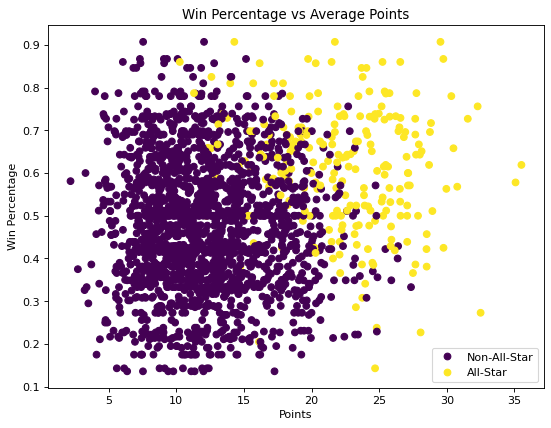

In [19]:
# scatterplots based on several important metrics
figure(figsize=(8, 6), dpi=80)
scatter = plt.scatter(only20['PTS'],only20['W_PCT'],c=only20['Selected?'],cmap='viridis')
plt.xlabel('Points')
plt.ylabel('Win Percentage')
plt.title('Win Percentage vs Average Points')
classes = ['Non-All-Star','All-Star']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig('figures/winpoints.png')
plt.show()

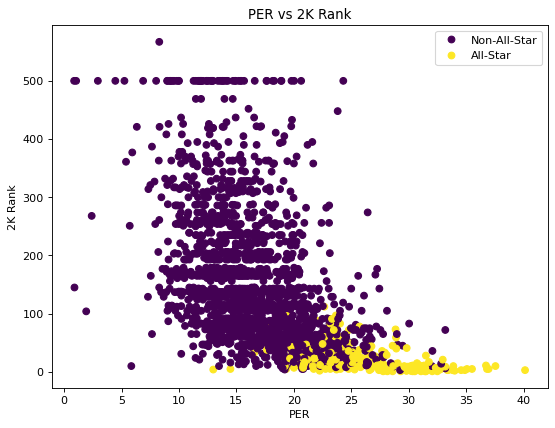

In [20]:
# scatterplots based on several important metrics
figure(figsize=(8, 6), dpi=80)
scatter = plt.scatter(only20['PER'],only20['2KRank'],c=only20['Selected?'],cmap='viridis')
plt.xlabel('PER')
plt.ylabel('2K Rank')
plt.title('PER vs 2K Rank')
classes = ['Non-All-Star','All-Star']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig('figures/per2k.png')
plt.show()

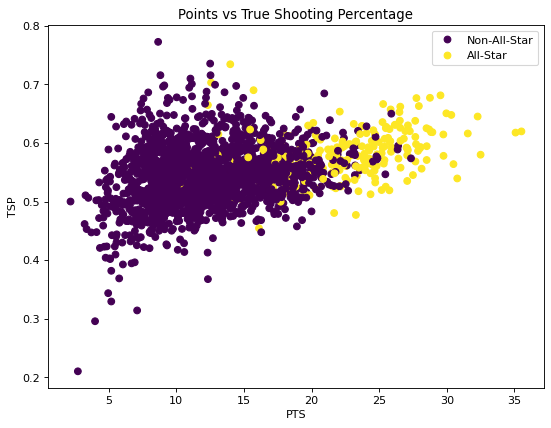

In [21]:
# scatterplots based on several important metrics
figure(figsize=(8, 6), dpi=80)
scatter = plt.scatter(only20['PTS'],only20['TSP'],c=only20['Selected?'],cmap='viridis')
plt.xlabel('PTS')
plt.ylabel('TSP')
plt.title('Points vs True Shooting Percentage')
classes = ['Non-All-Star','All-Star']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig('figures/pointstsp.png')
plt.show()

The below creates a table that compares statistics for All-Stars vs non-all-stars (only players with 20+ minutes considered).

In [22]:
# create table comparing all-star vs non all-star performance
comparetable = pd.DataFrame((only20[only20['Selected?']==1].mean(), 
                            only20[only20['Selected?']==0].mean(), 
                            only20[only20['Selected?']==1].mean() - only20[only20['Selected?']==0].mean()))

# set index and keep only select columns
comparetable['Index'] = ['All-Star','Other','Differnce']
comparetable = comparetable.set_index('Index')[['Minutes', 'PTS','PER','TSP','W_PCT','OREB', 'DREB','AST', 'STL', 'BLK', 'TO', 'AST', 'STL', 'BLK','PLUS_MINUS']]

# round
comparetable = comparetable.round(decimals=2)
comparetable

,Minutes,PTS,PER,TSP,W_PCT,OREB,DREB,AST,STL,BLK,TO,AST,STL,BLK,PLUS_MINUS
Index,,,,,,,,,,,,,,,
All-Star,32.98,22.28,25.85,0.58,0.61,1.46,5.80,5.11,1.31,0.81,2.84,5.11,1.31,0.81,4.15
Other,26.65,12.13,16.49,0.54,0.47,1.13,3.75,2.68,0.91,0.53,1.65,2.68,0.91,0.53,-0.13
Differnce,6.33,10.14,9.37,0.04,0.14,0.33,2.05,2.43,0.39,0.28,1.19,2.43,0.39,0.28,4.28


Do PCA to see how distinct classes are

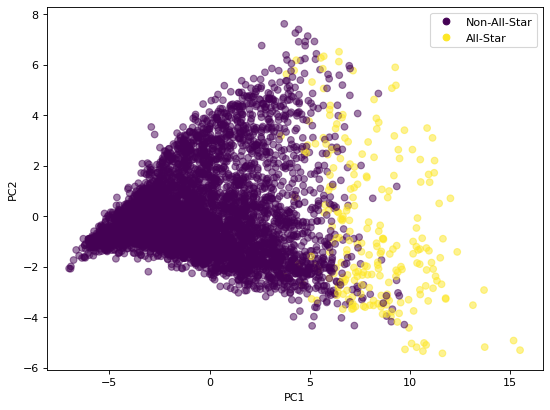

Explained Variance: 48.33364993129613


In [23]:
# get rid of target variable
X_pca = df.drop(['Selected?'],axis=1).values

# use standard scaler on data
X_pca = StandardScaler().fit_transform(X_pca)

# two-component PCA
pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_pca)

explained_variance = 100*sum(pca.explained_variance_ratio_)

# plot two principal components color-coded by cluster
figure(figsize=(8, 6), dpi=80)
pc1 = X_transform[:,0]
pc2 = X_transform[:,1]
plt.scatter(pc1, pc2, c=grouped['Selected?'], cmap='viridis',alpha=.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig('figures/pca.png')
plt.show()

print('Explained Variance:', explained_variance)

# Model Fittting

Remove 2020 data. Split remaining data into test/train. Use smote oversampling on training data to balance classes and scale both test and training data using min max (allows for NB). Also try various sets of features.

In [24]:
# separate 2020 data
dftest = df[df['season']==2020]
df = df[df['season']!=2020]

In [25]:
# test different sumbsets of features
normal = ['Selected?','season']
irrelevant = ['Selected?','season','FGA','FG3A','FTA']
few = ['Selected?','season','FGA','FG3A','FTA','Starting_Position_C', 'Starting_Position_F',
       'Starting_Position_G', 'Starting_Position_None', 'CONFERENCE_East',
       'CONFERENCE_West','FGM','FTM']

# split non 2020 data into test/train
X_train, X_test, y_train, y_test = train_test_split(df.drop(normal,axis=1), df['Selected?'], 
                                                    train_size = 0.67, random_state = 13)

In [26]:
# oversample
X_train, y_train = BorderlineSMOTE(random_state=0).fit_sample(X_train, y_train)

In [27]:
# scale 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Fit various models with oversampled training data and evaluate which model is most promising.

#### Choose Algorithm

*Multinomial Naive Bayes*

In [28]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_hat_nb = nb.predict(X_test)
y_hat_nb_train = nb.predict(X_train)
y_prob_nb = nb.predict_proba(X_test)[:,1]

print("Training Accuracy:", metrics.accuracy_score(y_train, y_hat_nb_train), 
      "\nTesting Accuracy:", metrics.accuracy_score(y_test, y_hat_nb), 
      "\nF1 Score:", metrics.f1_score(y_test, y_hat_nb), 
      "\nAUC:", roc_auc_score(y_test, y_prob_nb))

confusion_matrix(y_test, y_hat_nb)

Training Accuracy: 0.9366270949720671 
Testing Accuracy: 0.8557887610020312 
F1 Score: 0.40668523676880225 
AUC: 0.9847305155524334


array([[1191,  213],
       [   0,   73]], dtype=int64)

In [29]:
# if limit yes's to the same amount as in the test data, what proportion do we get right
frame = { 'Prob': y_prob_nb, 'Act': y_test }
sum(pd.DataFrame(frame).sort_values(by='Prob',ascending=False).head(sum(y_test))['Act'])/sum(y_test)

0.7123287671232876

*Logistic Regression*

In [30]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

y_hat_lr = lr.predict(X_test)
y_hat_lr_train = lr.predict(X_train)
y_prob_lr = lr.predict_proba(X_test)[:,1]

print("Training Accuracy:", metrics.accuracy_score(y_train, y_hat_lr_train), 
      "\nTesting Accuracy:", metrics.accuracy_score(y_test, y_hat_lr), 
      "\nF1 Score:", metrics.f1_score(y_test, y_hat_lr), 
      "\nAUC:", roc_auc_score(y_test, y_prob_lr))

confusion_matrix(y_test, y_hat_lr)

Training Accuracy: 0.9818435754189944 
Testing Accuracy: 0.9485443466486121 
F1 Score: 0.6513761467889908 
AUC: 0.9925555165281192


array([[1330,   74],
       [   2,   71]], dtype=int64)

In [31]:
# if limit yes's to the same amount as in the test data, what proportion do we get right
frame = { 'Prob': y_prob_lr, 'Act': y_test }
sum(pd.DataFrame(frame).sort_values(by='Prob',ascending=False).head(sum(y_test))['Act'])/sum(y_test)

0.8082191780821918

*Decision Tree*

In [32]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_hat_dt = dt.predict(X_test)
y_hat_dt_train = dt.predict(X_train)
y_prob_dt = dt.predict_proba(X_test)[:,1]


print("Training Accuracy:", metrics.accuracy_score(y_train, y_hat_dt_train), 
      "\nTesting Accuracy:", metrics.accuracy_score(y_test, y_hat_dt), 
      "\nF1 Score:", metrics.f1_score(y_test, y_hat_dt), 
      "\nAUC:", roc_auc_score(y_test, y_prob_dt))

confusion_matrix(y_test, y_hat_dt)

Training Accuracy: 1.0 
Testing Accuracy: 0.9390656736628301 
F1 Score: 0.5108695652173914 
AUC: 0.7991257854271552


array([[1340,   64],
       [  26,   47]], dtype=int64)

In [33]:
frame = { 'Prob': y_prob_dt, 'Act': y_test }
sum(pd.DataFrame(frame).sort_values(by='Prob',ascending=False).head(sum(y_test))['Act'])/sum(y_test)

0.4794520547945205

*Random Forest*

In [34]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_hat_rf = rf.predict(X_test)
y_hat_rf_train = rf.predict(X_train)
y_prob_rf = rf.predict_proba(X_test)[:,1]


print("Training Accuracy:", metrics.accuracy_score(y_train, y_hat_rf_train), 
      "\nTesting Accuracy:", metrics.accuracy_score(y_test, y_hat_rf), 
      "\nF1 Score:", metrics.f1_score(y_test, y_hat_rf), 
      "\nAUC:", roc_auc_score(y_test, y_prob_rf))

confusion_matrix(y_test, y_hat_rf)

Training Accuracy: 1.0 
Testing Accuracy: 0.972241029113067 
F1 Score: 0.7573964497041421 
AUC: 0.9905553604183741


array([[1372,   32],
       [   9,   64]], dtype=int64)

In [35]:
frame = { 'Prob': y_prob_rf, 'Act': y_test }
sum(pd.DataFrame(frame).sort_values(by='Prob',ascending=False).head(sum(y_test))['Act'])/sum(y_test)

0.7671232876712328

*Gradient Boosting*

In [36]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_hat_gb = gb.predict(X_test)
y_hat_gb_train = gb.predict(X_train)
y_prob_gb = gb.predict_proba(X_test)[:,1]


print("Training Accuracy:", metrics.accuracy_score(y_train, y_hat_gb_train), 
      "\nTesting Accuracy:", metrics.accuracy_score(y_test, y_hat_gb), 
      "\nF1 Score:", metrics.f1_score(y_test, y_hat_gb), 
      "\nAUC:", roc_auc_score(y_test, y_prob_gb))

confusion_matrix(y_test, y_hat_gb)

Training Accuracy: 0.9980796089385475 
Testing Accuracy: 0.965470548408937 
F1 Score: 0.7182320441988951 
AUC: 0.9879014947508098


array([[1361,   43],
       [   8,   65]], dtype=int64)

In [37]:
frame = { 'Prob': y_prob_gb, 'Act': y_test }
sum(pd.DataFrame(frame).sort_values(by='Prob',ascending=False).head(sum(y_test))['Act'])/sum(y_test)

0.7397260273972602

#### Feature Selection

Using all of the 2012-2019 data, find the most important features.

In [38]:
# use all 2012-2019 data - oversample and scale
X_feature, y_feature = BorderlineSMOTE(random_state=0).fit_sample(df.drop(normal,axis=1), df['Selected?'])
X_feature = scaler.fit_transform(X_feature)

# fit 
lr = LogisticRegression(solver='liblinear')
rfe = RFE(lr)
fit = rfe.fit(X_feature, y_feature)

In [40]:
# show ranking of features
for i in range(len(fit.ranking_)):
    print(df.drop(normal,axis=1).columns[i],fit.ranking_[i])

Minutes 2
FGM 1
FGA 4
FG3M 9
FG3A 15
FTM 1
FTA 3
OREB 6
DREB 1
AST 1
STL 14
BLK 1
TO 11
PF 7
PTS 1
PLUS_MINUS 16
PER 5
TSP 10
W_PCT 1
Jersey 13
2KRank 1
LastASG? 12
PriorASG 1
GP_Per 8
Starting_Position_C 1
Starting_Position_F 1
Starting_Position_G 1
Starting_Position_None 1
CONFERENCE_East 1
CONFERENCE_West 1


#### Prediction

Now make predictions on 2020 data

In [41]:
# list of dropped features
dropped = ['Selected?','season','FG3A','STL','TO','PLUS_MINUS','TSP','Jersey','LastASG?']

In [42]:
# geta all 2012-2019 data ready
X_feature, y_feature = BorderlineSMOTE(random_state=0).fit_sample(df.drop(dropped,axis=1), df['Selected?'])
X_feature = scaler.fit_transform(X_feature)

# get 2020 data ready
X2020 = dftest.drop(dropped,axis=1)
X2020 = scaler.fit_transform(X2020)

In [43]:
# fit the model and predict
lr = LogisticRegression(solver='liblinear')
lr.fit(X_feature, y_feature)

finalprob = lr.predict_proba(X2020)[:,1]
dftest['All-Star'] = finalprob.tolist()

In [44]:
# add player name so rows are identifiable
dftest['PLAYER_NAME'] = grouped[grouped['season']==2020]['PLAYER_NAME']

In [46]:
# fix James Harden's conference afiliation as he switched teams before the All-Star game
dftest.loc[(dftest['PLAYER_NAME']=='James Harden'),'CONFERENCE_East'] = 1
dftest.loc[(dftest['PLAYER_NAME']=='James Harden'),'CONFERENCE_West'] = 0

Show West Conference predicted All-Stars

In [53]:
dftest[dftest['CONFERENCE_West']==1].sort_values(by='All-Star', ascending=False).head(12)['PLAYER_NAME']

254         LeBron James
2200       Anthony Davis
2240      Damian Lillard
4593         Luka Doncic
1342       Stephen Curry
1662         Paul George
3362        Nikola Jokic
1986       Kawhi Leonard
4182    Donovan Mitchell
2845         Rudy Gobert
534           Chris Paul
1356       DeMar DeRozan
Name: PLAYER_NAME, dtype: object

Show East Conference predicted All-Stars

In [55]:
dftest[dftest['CONFERENCE_East']==1].sort_values(by='All-Star', ascending=False).head(12)['PLAYER_NAME']

847              Kevin Durant
2907    Giannis Antetokounmpo
3291              Joel Embiid
4587               Trae Young
1880             Kyrie Irving
4159             Jayson Tatum
3810         Domantas Sabonis
1316             James Harden
2217             Bradley Beal
2439          Khris Middleton
3910             Jaylen Brown
3801              Ben Simmons
Name: PLAYER_NAME, dtype: object

# Results

(Bold means failed to select)

#### Model's results
Original West Selections: Stephen Curry, Luka Doncic, Lebron James, Kawhi Leonard, Nikola Jokic, Damian Lillard, Donovan Mitchell, Chris Paul, Anthony Davis, Paul George, **Zion Williamson**, Rudy Gobert
* Picked Instead: DeMar DeRozan

Original East Selections: Bradley Beal, Kyrie Irving, Giannis Antetokounmpo, Kevin Durant, Joel Embiid, Jalyen Brown, James Harden, **Zach Lavine**, Ben Simmons, **Julius Randle**, Jayson Tatum, **Nikola Vucevic**
* Picked Instead: Trae Young, Domantas Sabonis (selected as replacement), Khris Middleton

#### Expert's results
Original West Selections: Stephen Curry, Luka Doncic, Lebron James, Kawhi Leonard, Nikola Jokic, Damian Lillard, Donovan Mitchell, **Chris Paul**, Anthony Davis, Paul George, Zion Williamson, Rudy Gobert
* Picked Instead: Devin Booker

Original East Selections: Bradley Beal, Kyrie Irving, Giannis Antetokounmpo, Kevin Durant, Joel Embiid, Jalyen Brown, James Harden, Zach Lavine, **Ben Simmons**, Julius Randle, Jayson Tatum, **Nikola Vucevic**
* Picked Instead: Trae Young, Bam Adebayo

https://www.nba.com/news/powells-potential-all-star-field